# 1. Packages

In [2]:
import re
import pandas as pd
import numpy as np
from io import StringIO
from PIL import Image
import matplotlib.pyplot as plt

# 2. Data Ingestion

In [3]:
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
DATA_DIRECTORY = "data"

def extract_df(filename):
    """
    Uses a filename to extract and return the information in dataframe format
    """
    with open(filename) as file:
        lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]
        df = pd.read_csv(StringIO(''.join(lines)), escapechar="/")
    
    return df

train_data = extract_df(TRAIN_FILENAME)
test_data = extract_df(TEST_FILENAME)
train_data

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.
...,...,...,...
29991,29995.jpg,8 1 2,A picture of a truck that is in the middle of ...
29992,29996.jpg,1,A plate topped with a pizza being cut with a s...
29993,29997.jpg,1,A man riding a snowboard on top of snow.
29994,29998.jpg,1,This photo shows people skiing in the mountains.


### 2.1 Creating Datasets

In [ ]:
class Sample:
    def __init__(self, id, images, labels, captions):
        """
        Collects and stores relevant information about each data entry.
        Attributes:
            - id, retrieved from the filename
            - image, a PIL image best used for displaying
            - label, a string containing labels. If there is more than one, separated by a space
            - captions, a string containing a description of the image
        """
        self.id = id
        self.image  = images
        self.label  = labels
        self.caption = captions  
    
    def display_data(self):
        plt.imshow(self.image)
        plt.axis('off')      
        plt.title(f"ImageID: {self.id} Label: {self.label}\n{self.caption}", wrap=True)
        plt.show()

    def get_filename(self):
        return "{self.id}.jpg"

# 
def retrieve_image(filename):
    """
    Returns an image from a given filename
    """
    return Image.open(f'{DATA_DIRECTORY}/{filename}')

def create_all_samples(dataframe):
    """
    Uses given dataframe to generate all samples which contain an id, image, label and caption.

    Returns a list of samples
    """
    samples = []
    for index, row in dataframe.iterrows():
        filename = row["ImageID"]
        image = retrieve_image(filename)
        label = row["Labels"]
        caption = row["Caption"]
        sample = Sample(filename[:-4], image, label, caption)
        samples.append(sample)
    
    return samples

# images = images_to_array(train_data)
samples = create_all_samples(train_data)


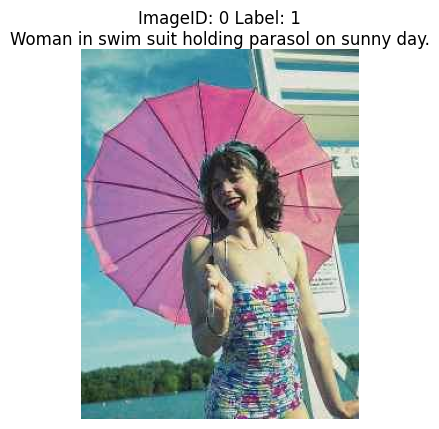

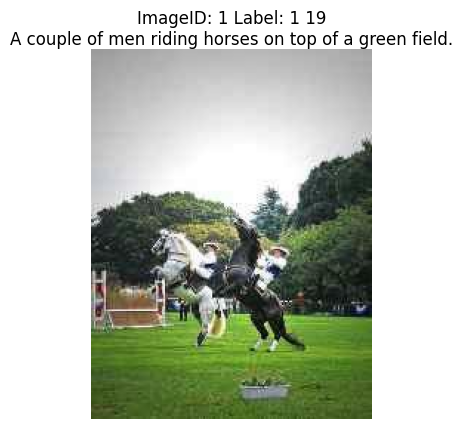

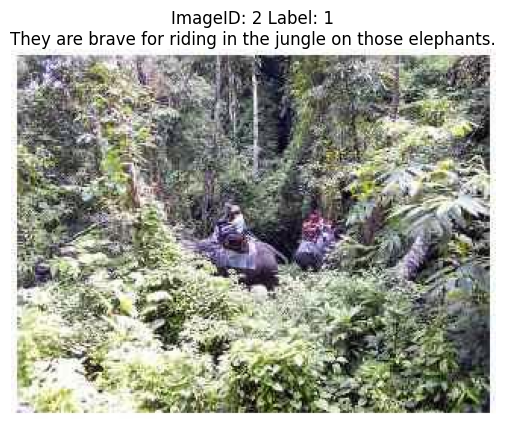

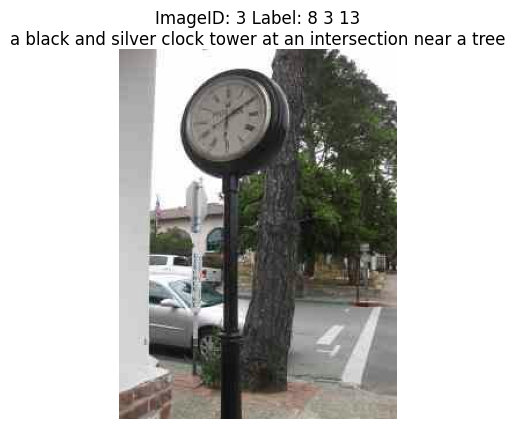

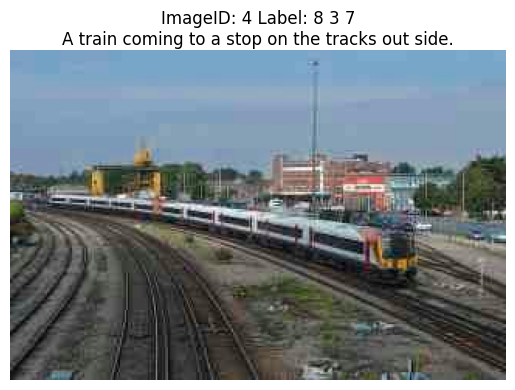

In [ ]:
for sample in samples[5:10]:
    sample.display_data()
# print(type(samples[0].image))